# Image Captioning with CNN/LSTM

## Approach
Recreate an image caption generator with:
* transfer learning using InceptionV3, a convolutional neural network (CNN) trained on ImageNet
* a Long Short Term Memory (LSTM) boosted by Glove6B, a semantic word co-occurence matrix trained on 6 billion words

## Required Libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
tf.keras.utils.to_categorical

<function tensorflow.python.keras.utils.np_utils.to_categorical>

In [ ]:
from tensorflow.python.keras.utils.np_utils import to_categorical

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
#from keras.utils import to_categorical ###MUST REVISIT

## Data 
* 8000 images of various animals and people in various scenes gathered from Flickr in 2014
* 1 text file (captions.txt) containing 5 human-generated captions for each image.

#### Step1: Define paths to files

In [ ]:
token_path = 'drive/MyDrive/Colab Notebooks/flickr8k/captions.txt'
images_path = 'drive/MyDrive/Colab Notebooks/flickr8k/Images/'
glove_path = 'drive/MyDrive/Colab Notebooks/glove6b/'

#### Step2: Create dictionary of descriptions
The document at "token_path" pairs an image ID (key) with 5 captions (values). From the text file, we create a Python dictionary.

In [ ]:
doc = open(token_path, 'r').read()
print(doc[:410])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cab


In [ ]:
#Convert the text to a Python dictionary
descriptions = dict()
#For each line in the document, split at the newline character ('/n').
for line in doc.split('\n'):
  #Divide the line
  tokens = line.split()
  #Exclude spaces
  if len(line) > 2:
    #Assign the parts of the split
    image_id = tokens[0].split('.')[0]
    image_desc = ' '.join(tokens[1:])
    if image_id not in descriptions:
      descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)

In [ ]:
#Examine the first few lines of the dictionary
print(list(descriptions.items())[:4])

[('image,caption', ['']), ('1000268201_693b08cb0e', ['child in a pink dress is climbing up a set of stairs in an entry way .', 'girl going into a wooden building .', 'little girl climbing into a wooden playhouse .', 'little girl climbing the stairs to her playhouse .', 'little girl in a pink dress going into a wooden cabin .']), ('1001773457_577c3a7d70', ['black dog and a spotted dog are fighting', 'black dog and a tri-colored dog playing with each other on the road .', 'black dog and a white dog with brown spots are staring at each other in the street .', 'dogs of different breeds looking at each other on the road .', 'dogs on pavement moving toward each other .']), ('1002674143_1b742ab4b8', ['little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'little girl is sitting in front of a large painted rainbow .', 'small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'is a girl with pigtails sitting in fr

#### Step 3: Clean text and inspect sample
Ensure token descriptions are lower case and free of punctuation.

In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

In [ ]:
#Re-examine descriptions after the cleaning.
print(list(descriptions.items())[:4])

[('image,caption', ['']), ('1000268201_693b08cb0e', ['child in a pink dress is climbing up a set of stairs in an entry way ', 'girl going into a wooden building ', 'little girl climbing into a wooden playhouse ', 'little girl climbing the stairs to her playhouse ', 'little girl in a pink dress going into a wooden cabin ']), ('1001773457_577c3a7d70', ['black dog and a spotted dog are fighting', 'black dog and a tricolored dog playing with each other on the road ', 'black dog and a white dog with brown spots are staring at each other in the street ', 'dogs of different breeds looking at each other on the road ', 'dogs on pavement moving toward each other ']), ('1002674143_1b742ab4b8', ['little girl covered in paint sits in front of a painted rainbow with her hands in a bowl ', 'little girl is sitting in front of a large painted rainbow ', 'small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it ', 'is a girl with pigtails sitting in front of a rain

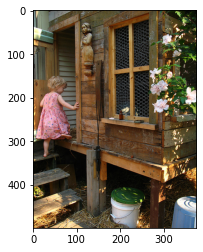

['child in a pink dress is climbing up a set of stairs in an entry way ',
 'girl going into a wooden building ',
 'little girl climbing into a wooden playhouse ',
 'little girl climbing the stairs to her playhouse ',
 'little girl in a pink dress going into a wooden cabin ']

In [ ]:
#Examine a sample of the imagery with captions.
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

#### Step 4: Create vocabulary of unique words 
Create a vocabulary of unique words among the 40000 captions (8000 images * 5 captions each). There are 8828 unique words in the 40000  captions.

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8745


In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

#### Step 5: Create training and test datasets
Load 6000 training image IDs and 2000 test image IDs into respective variables.

In [ ]:
def get_imgIDs(dict):
  return list(dict.keys())

In [ ]:
img_IDs = get_imgIDs(descriptions)
print(img_IDs[:5])
print("Images in total:",len(img_IDs))
train_img = img_IDs[1:6001]
test_img = img_IDs[6002:8002]
print("Images in training dataset:",len(train_img))
print("Images in test dataset:",len(test_img))

['image,caption', '1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815']
Images in total: 8092
Images in training dataset: 6000
Images in test dataset: 2000


#### Step 6: Create matching set of captions for training
At the same time, we add start/stop tokens to captions

In [ ]:
#Create the matching set of captions for training.
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train_img:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
#Re-examine descriptions after inserting start and stop tokens.
print(list(train_descriptions.items())[:4])

[('1000268201_693b08cb0e', ['startseq child in a pink dress is climbing up a set of stairs in an entry way endseq', 'startseq girl going into a wooden building endseq', 'startseq little girl climbing into a wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in a pink dress going into a wooden cabin endseq']), ('1001773457_577c3a7d70', ['startseq black dog and a spotted dog are fighting endseq', 'startseq black dog and a tricolored dog playing with each other on the road endseq', 'startseq black dog and a white dog with brown spots are staring at each other in the street endseq', 'startseq dogs of different breeds looking at each other on the road endseq', 'startseq dogs on pavement moving toward each other endseq']), ('1002674143_1b742ab4b8', ['startseq little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq', 'startseq little girl is sitting in front of a large painted rainbow ends

#### Step 7: Reduce vocabulary
To make the model more robust, limit vocabulary to words occuring 10 or more times.

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


#### Step 8: Create bi-directional map of words to indices
Create two dictionaries that map words to an index and vice versa. Also append 1 to vocabulary since we append 0’s to make all captions of equal length.

In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1
print(vocab_size)

1660


#### Step 9: Set the maximum length of a caption

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 37


#### Step 10: Create word co-occurence matrix with Glove

In [ ]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Building and Training

#### Step 1: Instantiate Model

In [ ]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)

#### Step 2: Preprocess Images

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
train_imgs = []
for img in train_img:
  train_imgs.append(images_path + img + '.jpg')
print(train_imgs[:5])
print(len(train_imgs))

['drive/MyDrive/Colab Notebooks/flickr8k/Images/1000268201_693b08cb0e.jpg', 'drive/MyDrive/Colab Notebooks/flickr8k/Images/1001773457_577c3a7d70.jpg', 'drive/MyDrive/Colab Notebooks/flickr8k/Images/1002674143_1b742ab4b8.jpg', 'drive/MyDrive/Colab Notebooks/flickr8k/Images/1003163366_44323f5815.jpg', 'drive/MyDrive/Colab Notebooks/flickr8k/Images/1007129816_e794419615.jpg']
6000


In [ ]:
test_imgs = []
for img in test_img:
  test_imgs.append(images_path + img + '.jpg')
print(test_imgs[:5])
print(len(test_imgs))  

['drive/MyDrive/Colab Notebooks/flickr8k/Images/3509611207_7645b1d28d.jpg', 'drive/MyDrive/Colab Notebooks/flickr8k/Images/3510218982_318f738b76.jpg', 'drive/MyDrive/Colab Notebooks/flickr8k/Images/3510219078_670b6b3157.jpg', 'drive/MyDrive/Colab Notebooks/flickr8k/Images/3510695264_ef460fa6cc.jpg', 'drive/MyDrive/Colab Notebooks/flickr8k/Images/3511062827_cd87871c67.jpg']
2000


In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:
encoding_train = {}
for img in train_imgs:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

In [ ]:
encoding_test = {}
for img in test_imgs:
    encoding_test[img[len(images_path):]] = encode(img)

#### Step 3: Create Model

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

#### Step 4: Compile and Train Model

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, 
                           train_features, 
                           wordtoix, 
                           max_length, 
                           batch_size)
model.fit(generator, 
          epochs=epochs, 
          steps_per_epoch=steps, 
          verbose=1)

Epoch 1/30
2000/2000 [==============================] - 230s 108ms/step - loss: 4.3618
Epoch 2/30
2000/2000 [==============================] - 215s 108ms/step - loss: 3.2987
Epoch 3/30
2000/2000 [==============================] - 215s 107ms/step - loss: 3.0637
Epoch 4/30
2000/2000 [==============================] - 215s 107ms/step - loss: 2.9258
Epoch 5/30
2000/2000 [==============================] - 214s 107ms/step - loss: 2.8299
Epoch 6/30
2000/2000 [==============================] - 212s 106ms/step - loss: 2.7577
Epoch 7/30
2000/2000 [==============================] - 215s 107ms/step - loss: 2.6998
Epoch 8/30
2000/2000 [==============================] - 215s 108ms/step - loss: 2.6527
Epoch 9/30
2000/2000 [==============================] - 215s 108ms/step - loss: 2.6126
Epoch 10/30
2000/2000 [==============================] - 215s 107ms/step - loss: 2.5755
Epoch 11/30
2000/2000 [==============================] - 216s 108ms/step - loss: 2.5483
Epoch 12/30
2000/2000 [==================

## Model Predictions

#### Step 1: Define Greedy Search

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

#### Step 2: Define Beam Search

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

#### Step 3: Evaluations

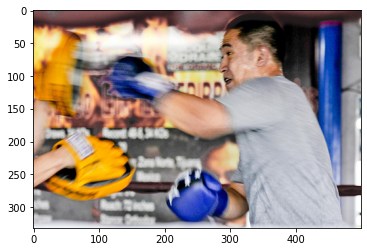

Greedy: man in a blue shirt is blowing a basketball
Beam Search, K = 3: man in a blue shirt is holding a sword on his hand
Beam Search, K = 5: man in a blue shirt is holding a sword on his hand
Beam Search, K = 7: man in a blue shirt is doing a hand flip as he makes a face


In [ ]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))


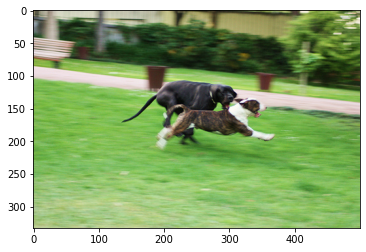

Greedy: black dog is running on the grass
Beam Search, K = 3: black and white dog is playing with a stick
Beam Search, K = 5: black and white dog plays with a stick
Beam Search, K = 7: black and white dog is playing with a ball in the grass


In [ ]:
pic = list(encoding_test.keys())[2]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))


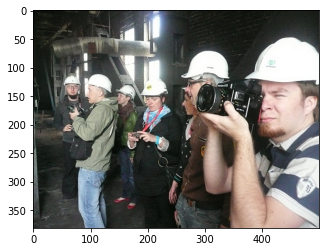

Greedy: man in a blue shirt and tie is smiling
Beam Search, K = 3: man in a blue shirt with a cowboy hat
Beam Search, K = 5: group of people are standing in front of a store
Beam Search, K = 7: group of people are standing in front of a store


In [ ]:
pic = list(encoding_test.keys())[3]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))


In [ ]:
def write_caption(x):
  pic = list(encoding_test.keys())[x]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()

  print("Greedy:",greedySearch(image))
  print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
  print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
  print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))


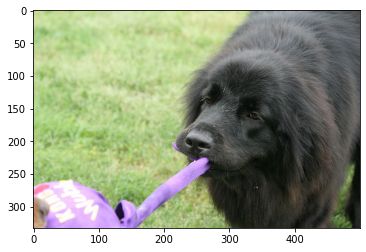

Greedy: black dog is running on the sidewalk
Beam Search, K = 3: black and white dog with a red collar is walking on the sidewalk
Beam Search, K = 5: black and white dog with a red collar is walking on the sidewalk
Beam Search, K = 7: black and white dog with a black collar plays with a brown dog


In [ ]:
write_caption(4)

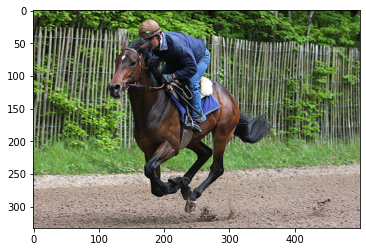

Greedy: bull and a bull are racing on a track
Beam Search, K = 3: man in a cowboy hat is riding a bull at a rodeo
Beam Search, K = 5: man is riding a bull at a rodeo
Beam Search, K = 7: man in a cowboy hat is riding a bull at a rodeo


In [ ]:
write_caption(5)

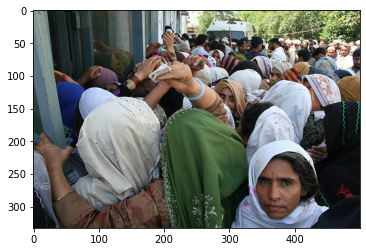

Greedy: group of people are gathered in a line of a white and white bus
Beam Search, K = 3: group of people stand in front of a statue of a parked
Beam Search, K = 5: group of people are standing in front of a statue of a statue of a store
Beam Search, K = 7: group of people stand in front of a statue of a parked


In [ ]:
write_caption(6)

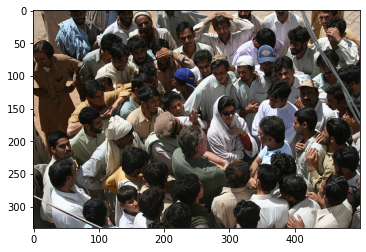

Greedy: group of people are gathered in a gym
Beam Search, K = 3: group of people are gathered in front of a statue of a large crowd
Beam Search, K = 5: large group of people stand in front of a statue of a building
Beam Search, K = 7: large group of people stand in front of a statue of a building


In [ ]:
write_caption(7)

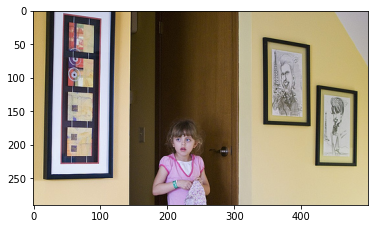

Greedy: girl in a pink dress is standing in front of a fountain
Beam Search, K = 3: girl in a pink dress is holding a pink balloon
Beam Search, K = 5: little girl in a pink shirt is playing with a large ribbon
Beam Search, K = 7: group of people are standing in front of a statue of a brick wall


In [ ]:
write_caption(8)

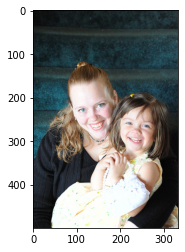

Greedy: young girl is sitting on a bed with a bear
Beam Search, K = 3: little girl in a pink shirt is blowing a pillow of bread
Beam Search, K = 5: little girl in a pink shirt is blowing a pillow of bread
Beam Search, K = 7: little girl wearing a pink shirt is blowing a pillow of bread


In [ ]:
write_caption(9)

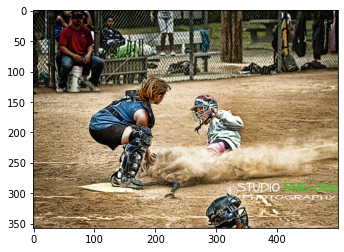

Greedy: man in a blue uniform is a ball
Beam Search, K = 3: men in athletic uniforms are playing basketball
Beam Search, K = 5: group of men on a basketball court
Beam Search, K = 7: group of men on a basketball court


In [ ]:
write_caption(10)